In [9]:
#TO BE USED AS DEPLOY CODE

import os
import tensorflow as tf
import numpy as np
import cv2 as cv
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Input
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import Initializer
from keras import backend as K
from keras.utils import plot_model
import matplotlib.pyplot as plt
import h5py
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #This disables Tensorflow deprecation messages

#Hyperparameters

iter = 2000
batch_size = 16
reshape = (1,112,92,1)

left = np.load('left.npy')
right = np.load('right.npy')
target = np.load('target.npy')
hansonid = np.load('hanson.npy')

def prediction(image): #Where image: loaded numpy array of query image
    userid = np.load('hanson.npy')
    userid = hansonid.reshape(reshape)
    image = image.reshape(reshape)
    outputPair = [userid, image]
    value = gen1.predict(outputPair)
    if value > 0.9:
        id = True
    if value <= 0.9:
        id = False

    return id

def modelTest(index):
    a = left[index,:,:,:]
    b = right[index,:,:,:]
    testpair = [a.reshape(1,112,92,1), b.reshape(1,112,92,1)]
    print(gen1.predict(testpair))
    plt.imshow(a)
    plt.imshow(b)
    return

def getBatch(batchsize):
    left = np.load('left.npy')
    right = np.load('right.npy')
    batchindex = np.random.randint(0,int(199-batchsize))
    ubatchindex = np.random.randint(200,int(399-batchsize))
    batchleft = np.empty((0,112,92,1), dtype = 'float32')
    batchright = np.empty((0,112,92,1), dtype = 'float32')

    batchtarget = np.concatenate([np.ones(int(batchsize)),np.zeros(int(batchsize))])

    for i in range(batchindex, int(batchindex+batchsize)):
        batchleft = np.concatenate([batchleft, left[i,:,:,:].reshape(1,112,92,1)])
        batchright = np.concatenate([batchright, right[i,:,:,:].reshape(1,112,92,1)])
    for i in range(ubatchindex, int(ubatchindex+batchsize)):
        batchleft = np.concatenate([batchleft, left[i,:,:,:].reshape(1,112,92,1)])
        batchright = np.concatenate([batchright, right[i,:,:,:].reshape(1,112,92,1)])

    return batchleft, batchright, batchtarget

def genSiamese(inputshape):

    inputleft = Input(inputshape)
    inputright = Input(inputshape)

    #Convolutional Network

    model = Sequential()
    model.add(Conv2D(64,(10,10),activation='relu', input_shape = inputshape, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(7,7),activation='relu', input_shape = inputshape, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(3,3),activation='relu', input_shape = inputshape, kernel_regularizer = l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(256,(3,3),activation='relu', input_shape = inputshape, kernel_regularizer = l2(2e-4)))

    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3)))

    encodeleft = model(inputleft)
    encoderight = model(inputright)

    #Computing absolute difference between encodings

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1])) #Vector subtraction
    L1_distance = L1_layer([encodeleft, encoderight])

    prediction = Dense(1, activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[inputleft,inputright], outputs = prediction)

    siamese_net.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.00006))

    return siamese_net

In [10]:
gen1 = genSiamese((112,92,1))
print("------------------------ NETWORK SUMMARY ------------------------")
gen1.summary()
print("-----------------------------------------------------------------")
print("Loading network weights")
gen1.load_weights('gen1weights') #gen1weights.hdf5 is too large to push to github so it wont appear in this repo


------------------------ NETWORK SUMMARY ------------------------
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         42797888    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)    

[[0.9987119]]


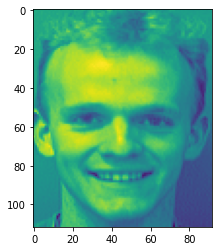

In [15]:
modelTest(20)